# Visualize Air Pollution in Bangkok

## Background

Air pollution is a pollution threat in many Asian countries. Being informed about the current outdoor air quality helps you protect yourself. Recently, Thai people become more concern about local air pollution due to the high level of pollution in Bangkok in winter of 2019. Air polution is reported as air quality index (AQI). The high AQI mean bad air pollution. The major pollutant was the small size particle pollution (PM2.5). Still there are a lot of misconceptions and debates about the causes of the pollution and degree of hazard of particles. 

This notebook tried a way to answer answer some of the questions about air pollution through data visualization. Moreover, it includes how to generate these vizs are generated so that the same method can be applied to your local air quality measurement. I was inspired by the work from  a Facebook post by [Data-addict] (https://scontent-sjc3-1.xx.fbcdn.net/v/t1.0-9/34398114_426447444494150_7618108699801812992_n.png?_nc_cat=108&_nc_ht=scontent-sjc3-1.xx&oh=0ac2b42de652b994d8f1994ecb835418&oe=5CF14B7F)

In [182]:
import sys
sys.path.append(r'C:\Users\Benny\fastai\old')
from pathlib import Path
from fastai.imports import *
import seaborn as sns

import statsmodels.api as sm
import datetime 

In [2]:
trend_aqi = pd.read_csv('data/google_trend_aqi.csv', infer_datetime_format=True,
                       skiprows=3, names= ['date','aqi_trend'])
trend_pm25 = pd.read_csv('data/google_trend_pm25.csv', infer_datetime_format=True,
                       skiprows=3, names= ['date','pm25_trend'])

trend = trend_aqi.merge(trend_pm25, on=['date'], how ='outer')

In [3]:
trend.head()

,date,aqi_trend,pm25_trend
0,2014-02-23,0,<1
1,2014-03-02,<1,<1
2,2014-03-09,1,0
3,2014-03-16,1,<1
4,2014-03-23,1,<1


In [4]:
trend.tail()

,date,aqi_trend,pm25_trend
256,2019-01-20,61,40
257,2019-01-27,100,100
258,2019-02-03,58,49
259,2019-02-10,38,26
260,2019-02-17,32,15


In [5]:
trend['date'] =  pd.to_datetime(trend['date'],yearfirst=True)


In [6]:
trend['aqi_trend'] = trend['aqi_trend'].str.replace('<1','0')
trend['pm25_trend'] = trend['pm25_trend'].str.replace('<1','0')


In [7]:
trend[['aqi_trend', 'pm25_trend']] = trend[[
    'aqi_trend', 'pm25_trend']].astype(np.int32)

In [8]:
trend.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261 entries, 0 to 260
Data columns (total 3 columns):
date          261 non-null datetime64[ns]
aqi_trend     261 non-null int32
pm25_trend    261 non-null int32
dtypes: datetime64[ns](1), int32(2)
memory usage: 6.1 KB


As mentioned above, more people are aware of the air pollution problem, how do I know that ? There are surge of Google search for the words 'PM2.5' and 'AQI' in Thailand around 2019. 

Text(0.5, 1.0, 'Google Search Frequency in Thailand')

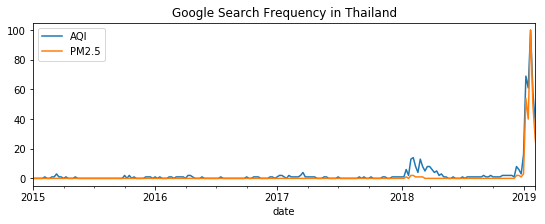

In [11]:
trend.plot('date', ['aqi_trend', 'pm25_trend'], kind='line',
           label=['AQI','PM2.5'], xlim=['2015-01-01', '2019-02-07'],
          figsize=(9,3))
plt.title('Google Search Frequency in Thailand')

How AQI are calculated? That depends on the law in different countries. They mostly divided into four pollutants source: ground level ozone(O3), particle pollution (PM2.5 and PM10), toxic gas (NO2, CO, SO2). The table below shows different pollutants from various stations in Thailand on February 2, 2019. There are level of CO, NO2, O3, SO2, PM10 and PM2.5. Most level are normal except, high level of PM2.5 in some region. 

PM2.5 are particle of size smaller than 2.5 micron. PM2.5 concentation higher than 35 ug/m3 is considered moderate (giving AQI 100) and above 55.4 ug/m3 is consider unhealthy (AQI 150). Since AQI is calculated from the highest level of pollutant aveage over 24 hours([1](https://airnow.gov/index.cfm?action=aqi_brochure.index)), we focus this notebook on PM 2.5 data. 

What cause high air pollution in Bangkok last winter? The sources of PM2.5 particle can be car engine, power plants, and agricultural waste burning. There are number of theories: still wind, old diesel cars, near by power plants, and agricultural burning from other provinces. Let's try to answer some of these questions through visualization. 

![AQI report Thailand](data/aqi_2019_02_19.png)

The government official website only provides a month historical data. I use the PM 2.5 from Berkeley Earth [website](http://berkeleyearth.lbl.gov/air-quality/maps/cities/Thailand/). Detail about how to use Python to scrap this data can be found in this [notebook](https://github.com/worasom/aqi_thailand/blob/master/webscraping-PM25.ipynb). Also if you are interested in scrapping the data from the government website, you may find this [notebook](https://github.com/worasom/aqi_thailand/blob/master/webscraping-AQI.ipynb) useful.

In [255]:
# inspecting the top of the files 
with open('data/Bangkok.txt','r') as f:
    for i in range(12):
        print(f.readline())

% Country: Thailand

% City: Bangkok

% City (ASCII): Bangkok

% Region: Bangkok

% Region (ASCII): Bangkok

% Population: 5104476

% Latitude: 13.754

% Longitude: 100.5014

% Time Zone: Asia/Bangkok

% Year, Month, Day, UTC Hour, PM2.5, PM10_mask, Retrospective

2016	3	3	8	62.9	1.00	0

2016	3	3	9	62.9	1.00	0



In [294]:
pm25 = pd.read_csv('data/Bangkok.txt', sep='\t', 
                   header=None, skiprows=10)

In [295]:
pm25.head()

,0,1,2,3,4,5,6
0,2016,3,3,8,62.9,1.0,0
1,2016,3,3,9,62.9,1.0,0
2,2016,3,3,10,55.5,1.0,0
3,2016,3,3,11,55.5,1.0,0
4,2016,3,3,12,47.9,1.0,0


In [296]:
#assemble datetime column 
pm25['Time'] = pd.to_datetime({'year': pm25[0], 'month': pm25[1], 'day':pm25[2],'hour': pm25[3]})

In [297]:
pm25.head()

,0,1,2,3,4,5,6,Time
0,2016,3,3,8,62.9,1.0,0,2016-03-03 08:00:00
1,2016,3,3,9,62.9,1.0,0,2016-03-03 09:00:00
2,2016,3,3,10,55.5,1.0,0,2016-03-03 10:00:00
3,2016,3,3,11,55.5,1.0,0,2016-03-03 11:00:00
4,2016,3,3,12,47.9,1.0,0,2016-03-03 12:00:00


In [298]:
pm25.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23667 entries, 0 to 23666
Data columns (total 8 columns):
0       23667 non-null int64
1       23667 non-null int64
2       23667 non-null int64
3       23667 non-null int64
4       23667 non-null float64
5       23667 non-null float64
6       23667 non-null int64
Time    23667 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(5)
memory usage: 1.4 MB


In [299]:
#convert time zone
pm25['Time'] = pm25['Time'].dt.tz_localize('UTC').dt.tz_convert('Asia/Bangkok')
pm25['Time'] = pm25['Time'].dt.tz_localize(None)

In [300]:
pm25.head()

,0,1,2,3,4,5,6,Time
0,2016,3,3,8,62.9,1.0,0,2016-03-03 15:00:00
1,2016,3,3,9,62.9,1.0,0,2016-03-03 16:00:00
2,2016,3,3,10,55.5,1.0,0,2016-03-03 17:00:00
3,2016,3,3,11,55.5,1.0,0,2016-03-03 18:00:00
4,2016,3,3,12,47.9,1.0,0,2016-03-03 19:00:00


In [301]:
pm25=pm25.drop([0,1,2,3,5,6],axis=1)

In [302]:
pm25.columns = ['PM2.5', 'Time']
pm25[['Time','PM2.5']].to_csv('data/bkk_pm25.csv',index=False)

## Exploratory Data Analaysis

In this section, I use exploratory data analysis and feature engineering to answer the following questions:

* Is the problem getting worse?
* Which months have the highest level of PM2.5 in Bangkok? 
* What time has the highest pollution?
* Is the pollution lower during the holiday?

In [599]:
bkk = pd.read_csv('data/bkk_pm25.csv')
bkk.head()

,Time,PM2.5
0,2016-03-03 15:00:00,62.9
1,2016-03-03 16:00:00,62.9
2,2016-03-03 17:00:00,55.5
3,2016-03-03 18:00:00,55.5
4,2016-03-03 19:00:00,47.9


In [600]:
bkk['Time'] = pd.to_datetime(bkk['Time'])
bkk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23667 entries, 0 to 23666
Data columns (total 2 columns):
Time     23667 non-null datetime64[ns]
PM2.5    23667 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 369.9 KB


In [602]:
bkk['PM2.5avg'] = bkk['PM2.5'].rolling(24).mean()
bkk = bkk.dropna()

In [533]:
import matplotlib.dates as mdates
import matplotlib as mpl

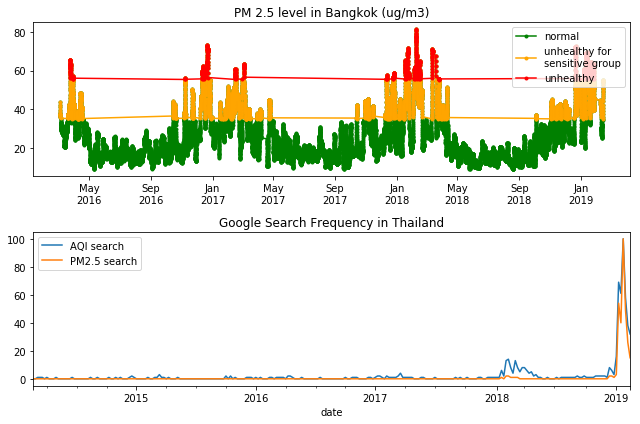

In [598]:
fig = plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(211)
ax1.plot(pm25['PM2.5avg'], c='green', marker='.')
ax1.plot(pm25[pm25['PM2.5avg'] >= 35]['PM2.5avg'], c='orange', marker='.')
ax1.plot(pm25[pm25['PM2.5avg'] >= 55.4]['PM2.5avg'], c='red', marker='.')
plt.title("PM 2.5 level in Bangkok (ug/m3)")
plt.legend(['normal', 'unhealthy for \nsensitive group', 'unhealthy'], loc='upper right')
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b\n%Y"))
#plt.xlim(pm25['Time'].min(), pm25['Time'].max())
# ax1.set_xticklabels([])
# ax1.xaxis.set_visible(False)



ax2 = fig.add_subplot(212)
trend.plot('date', ['aqi_trend', 'pm25_trend'], kind='line',
           label=['AQI search', 'PM2.5 search'], ax=ax2)
plt.title('Google Search Frequency in Thailand')
#plt.xlim(pm25['Time'].min(), pm25['Time'].max())
#ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b\n%Y"))
plt.tight_layout()

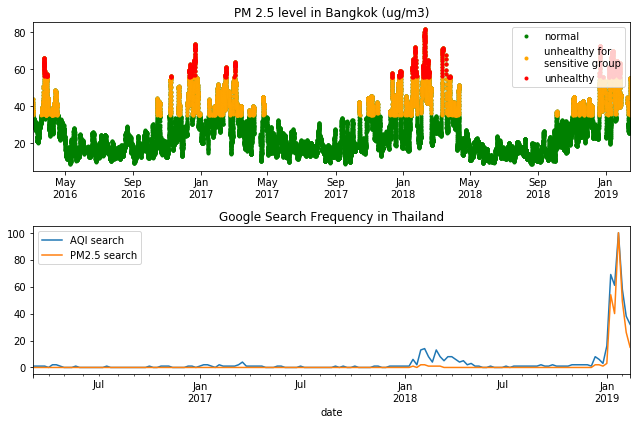

In [605]:
fig = plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(211)
ax1.plot_date(bkk['Time'], bkk['PM2.5avg'], c='green', marker='.')
ax1.plot_date(bkk[bkk['PM2.5avg'] >= 35]['Time'],
              bkk[bkk['PM2.5avg'] >= 35]['PM2.5avg'], c='orange', marker='.')
ax1.plot_date(bkk[bkk['PM2.5avg'] >= 55.4]['Time'],
              bkk[bkk['PM2.5avg'] >= 55.4]['PM2.5avg'], c='red', marker='.')
plt.title("PM 2.5 level in Bangkok (ug/m3)")
plt.legend(['normal', 'unhealthy for \nsensitive group', 'unhealthy'], loc='upper right')
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b\n%Y"))
plt.xlim(bkk['Time'].min(), bkk['Time'].max())
# ax1.set_xticklabels([])
# ax1.xaxis.set_visible(False)



ax2 = fig.add_subplot(212)
trend.plot('date', ['aqi_trend', 'pm25_trend'], kind='line',
           label=['AQI search', 'PM2.5 search'], ax=ax2)
plt.title('Google Search Frequency in Thailand')
plt.xlim(bkk['Time'].min(), bkk['Time'].max())
#ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b\n%Y"))
plt.tight_layout()

In [541]:
pm25 = bkk.set_index('Time')

In [561]:
# featuare engineering 
pm25['Year'] = pm25.index.year
pm25['Month'] = pm25.index.strftime('%B')
pm25['DayofMonth'] = pm25.index.day
pm25['DayofWeek'] = pm25.index.strftime('%A')
pm25.to_csv('data/bkk_pm25_proc.csv')


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23644 entries, 2016-03-04 15:00:00 to 2019-02-14 03:00:00
Data columns (total 6 columns):
PM2.5         23644 non-null float64
PM2.5avg      23644 non-null float64
Year          23644 non-null int64
Month         23644 non-null object
DayofMonth    23644 non-null int64
DayofWeek     23644 non-null object
dtypes: float64(2), int64(2), object(2)
memory usage: 1.9+ MB


(                     PM2.5   PM2.5avg  Year  Month  DayofMonth DayofWeek
 Time                                                                    
 2016-03-04 15:00:00   34.2  43.520833  2016  March           4    Friday
 2016-03-04 16:00:00   35.0  42.358333  2016  March           4    Friday
 2016-03-04 17:00:00   30.0  40.987500  2016  March           4    Friday
 2016-03-04 18:00:00   25.6  39.741667  2016  March           4    Friday
 2016-03-04 19:00:00   32.1  38.766667  2016  March           4    Friday,
 None)

In [606]:
pm25 = pd.read_csv('data/bkk_pm25_proc.csv')
pm25.head(), pm25.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23644 entries, 0 to 23643
Data columns (total 7 columns):
Time          23644 non-null object
PM2.5         23644 non-null float64
PM2.5avg      23644 non-null float64
Year          23644 non-null int64
Month         23644 non-null object
DayofMonth    23644 non-null int64
DayofWeek     23644 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


(                  Time  PM2.5   PM2.5avg  Year  Month  DayofMonth DayofWeek
 0  2016-03-04 15:00:00   34.2  43.520833  2016  March           4    Friday
 1  2016-03-04 16:00:00   35.0  42.358333  2016  March           4    Friday
 2  2016-03-04 17:00:00   30.0  40.987500  2016  March           4    Friday
 3  2016-03-04 18:00:00   25.6  39.741667  2016  March           4    Friday
 4  2016-03-04 19:00:00   32.1  38.766667  2016  March           4    Friday,
 None)

The air pollution seem to be seasonal, with surge around winter seasion (Dec - Jan). In fact, the winter pollution exists since 2017, but public awareness has just increased recently.

Is the problem getting worse every year?

In [555]:
# find yearly PM2.5 average
pm25.groupby('Year').mean()['PM2.5avg']

Year
2016    24.376378
2017    25.117491
2018    25.037562
2019    43.118296
Name: PM2.5avg, dtype: float64

In [580]:
# number of day per year with particle lever higher than limit (AQI 100)
pm25[pm25['PM2.5avg'] > 35].resample('d').mean().groupby('Year').count()

,PM2.5,PM2.5avg,DayofMonth
Year,,,
2016.0,57,57,57
2017.0,79,79,79
2018.0,88,88,88
2019.0,27,27,27


In [581]:
# number of day per year with particle lever higher than limit (AQI 150)
pm25[pm25['PM2.5avg'] > 55].resample('d').mean().groupby('Year').count()

,PM2.5,PM2.5avg,DayofMonth
Year,,,
2016.0,16,16,16
2017.0,10,10,10
2018.0,25,25,25
2019.0,13,13,13


The average for 2019 is high because we only have the winter data, which has high pollution.This set of data does not have data in Jan-Feb of 2016, and 2015, which explain why the number of day is lower in 2016. The year 2018 has 25 days with very high AQI (from the Jan-Feb and Dec). Without more data, it's hard to judge if the situation is getting worse. 

To summarize, the yearly average is not increasing, but the number of days with high AQI seem to be higher. Another way to see trend for time series data is to look at the rate of change, which is shown below. 

(array([736420., 736511., 736603., 736695., 736785., 736876., 736968., 737060.]),
 <a list of 8 Text xticklabel objects>)

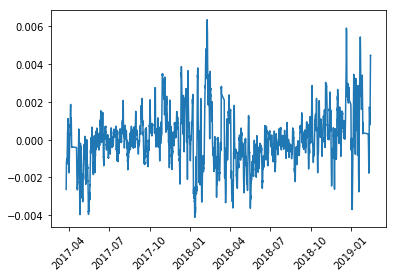

In [588]:
plt.plot(pm25['PM2.5avg'].diff().rolling(24*30*12).mean())
plt.xticks(rotation=45)

The rate of change is around zero except at the very end. This confirm that the problem is about the same every year. 

Bangkok is a tourist city, which month should you avoid going to Bangkok. If you are Bangkokians what is the best time to go for a jog? Is the air pollution better during the holiday when everyone is away?

In [568]:
pm25.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23644 entries, 2016-03-04 15:00:00 to 2019-02-14 03:00:00
Data columns (total 6 columns):
PM2.5         23644 non-null float64
PM2.5avg      23644 non-null float64
Year          23644 non-null int64
Month         23644 non-null object
DayofMonth    23644 non-null int64
DayofWeek     23644 non-null object
dtypes: float64(2), int64(2), object(2)
memory usage: 1.9+ MB


In [572]:
date_month_map = pd.crosstab(pm25['Month'], pm25['DayofMonth'], pm25['PM2.5avg'], aggfunc=np.mean)
month_name=pd.date_range('2014-01','2014-12', freq='MS').strftime("%B").tolist()
date_month_map = date_month_map.reindex(month_name)

In [573]:
date_month_map

DayofMonth,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
Month,,,,,,,,,,,,,,,,,,,,,
January,24.791667,23.341204,24.659954,28.017312,31.562269,38.960662,39.846009,33.909149,20.361775,25.523785,...,51.797917,42.682474,42.005340,43.346429,41.670486,33.694263,29.938225,30.535026,32.370052,33.980440
February,32.041667,40.262500,41.744184,38.406649,47.535638,48.282986,52.512784,55.965891,47.166793,41.762153,...,27.366033,22.841580,21.730469,26.169792,26.369048,27.253457,38.769022,NaN,NaN,NaN
March,40.948090,39.750521,43.545380,39.714750,34.859155,31.882262,32.204405,31.371009,28.304636,28.355026,...,32.704687,39.426852,42.799363,41.591432,32.851643,30.887563,38.104225,41.233920,36.388484,30.750121
April,28.121701,28.305242,29.971412,33.260563,30.385764,33.950579,32.791212,26.009115,29.545833,37.735243,...,27.453345,30.381503,32.842525,29.045958,26.545070,26.373846,26.100998,24.280035,26.540278,NaN
May,18.564331,13.246190,15.884742,17.569324,16.209028,17.925231,16.574306,15.590893,17.332523,15.193192,...,16.973900,19.681884,19.562621,14.608160,15.044155,16.216795,20.512619,17.403588,17.073553,18.459144
June,19.518349,17.635857,15.698333,12.158951,13.273472,13.461553,14.286845,14.475000,12.877574,15.132721,...,17.570129,18.222976,15.489345,12.783392,13.502836,14.920481,15.427523,15.932943,18.424933,NaN
July,17.026119,14.554977,15.759096,17.488512,18.633782,16.289352,15.111111,15.261534,15.619776,16.879042,...,14.868015,13.662265,16.730760,17.921159,16.340856,15.890317,15.028631,16.059954,17.223155,19.082465
August,19.154988,19.198333,18.803580,17.290000,17.423090,16.517361,15.701215,16.616377,16.492766,16.870350,...,17.832755,18.684918,19.572403,16.530298,16.660000,16.345714,14.629812,18.424941,18.879754,14.305282
September,15.323415,15.502267,13.140741,12.391406,11.868721,12.503925,14.283095,16.957675,20.450758,20.230804,...,21.512031,22.913393,20.289336,16.928212,16.164286,13.251995,13.674413,17.317882,18.985681,NaN


Text(0.5, 15.0, 'Day of Month')

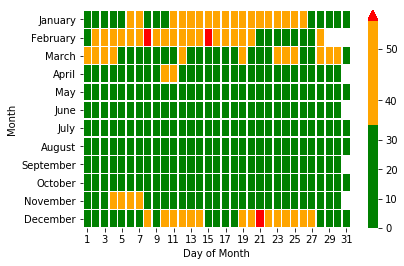

In [594]:
colors = ['green','orange','red']
levels = [0, 35.4, 55.4]
cmap, norm = mpl.colors.from_levels_and_colors(levels,colors,'max')
sns.heatmap(date_month_map, cmap=cmap, norm=norm, linewidth=0.5)
plt.xlabel('Day of Month')

In [122]:
pm25['PM2.5avg']= pm25['PM2.5'].rolling(24*14, min_periods=0).mean()

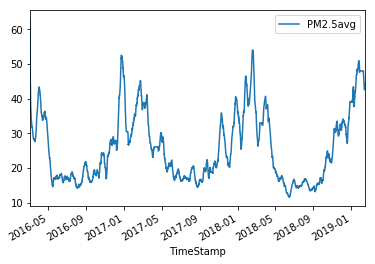

In [123]:
pm25.plot('TimeStamp','PM2.5avg')

In [150]:
pm25['dayOfWeek'] = pm25['TimeStamp'].dt.strftime('%A')

In [195]:
pm25['Timedelta'] = (pm25['TimeStamp'] - pm25['TimeStamp'].min())/datetime.timedelta(hours=1)
pm25.head()

,const,PM2.5,TimeStamp,PM2.5avg,Timedelta,dayOfWeek
0,1.0,62.9,2016-03-03 15:00:00+07:00,62.900000,0.0,Thursday
1,1.0,62.9,2016-03-03 16:00:00+07:00,62.900000,1.0,Thursday
2,1.0,55.5,2016-03-03 17:00:00+07:00,60.433333,2.0,Thursday
3,1.0,55.5,2016-03-03 18:00:00+07:00,59.200000,3.0,Thursday
4,1.0,47.9,2016-03-03 19:00:00+07:00,56.940000,4.0,Thursday


In [172]:
coeff, V = np.polyfit(pm25['Timedelta'], pm25['PM2.5'],1, cov=True)
p = np.poly1d(coeff)
y_pred = p(pm25['Timedelta'])

In [181]:
coeff, np.sqrt(np.diag(V))

(array([ 0.0001 , 24.13695]), array([0.00001, 0.1828 ]))

In [156]:
pm25.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23667 entries, 0 to 23666
Data columns (total 5 columns):
PM2.5        23667 non-null float64
TimeStamp    23667 non-null datetime64[ns, Asia/Bangkok]
PM2.5avg     23667 non-null float64
Timedelta    23667 non-null timedelta64[ns]
dayOfWeek    23667 non-null object
dtypes: datetime64[ns, Asia/Bangkok](1), float64(2), object(1), timedelta64[ns](1)
memory usage: 924.6+ KB


In [177]:
np.var(pm25['PM2.5'])/len(pm25)**2

3.5892524722261356e-07

In [229]:
pm25 = sm.add_constant(pm25)
est = sm.OLS(pm25['PM2.5avg'], sm.add_constant(pm25['Timedelta'])).fit()

In [230]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

prstd, iv_l, iv_u = wls_prediction_std(est)

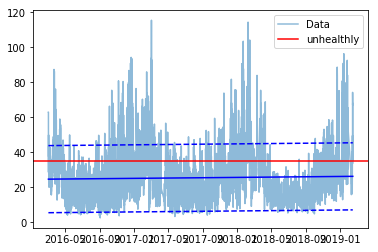

In [240]:
fig, ax = plt.subplots()
ax.plot(pm25['TimeStamp'], pm25['PM2.5'], label ='Data', alpha=0.5)
ax.plot(pm25['TimeStamp'], est.fittedvalues, 'b')
ax.plot(pm25['TimeStamp'], iv_l, 'b--')
ax.plot(pm25['TimeStamp'], iv_u, 'b--')
plt.axhline(y=35, color='r',label='unhealthly')
legend = ax.legend(loc="best")

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\seaborn\regression.py:223: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  X, y = np.c_[np.ones(len(self.x)), self.x], self.y


TypeError: invalid type promotion

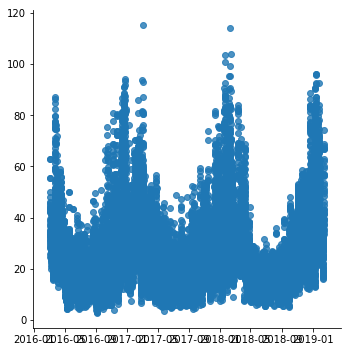

In [242]:
sns.lmplot(y='PM2.5', pm25['TimeStamp'].d, data=pm25) 

In [214]:
pm25['Timedelta'].shape

(23667,)